In [23]:
# Veri işleme kütüphaneleri
import pandas as pd
import numpy as np
import os
import shutil

# Model oluşturma ve performans metrikleri için
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

# Uyarıları kapatmak için (opsiyonel)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Ana klasör
dataset_dir = 'data'

# Tüm resimlerin listesini al
all_images = []
for class_dir in os.listdir(dataset_dir):  # 'with_mask', 'without_mask'
    class_path = os.path.join(dataset_dir, class_dir)
    for img in os.listdir(class_path):
        all_images.append((os.path.join(class_path, img), class_dir))  # (resim yolu, sınıf)

# %80 Eğitim/Validasyon ve %20 Test
train_val_data, test_data = train_test_split(
    all_images, 
    test_size=0.2, 
    random_state=42, 
    stratify=[label for _, label in all_images]  # Sınıf dengesi için
)

# Eğitim/Validasyon (%80) ve Test (%20) setlerini kontrol edelim
print(f"Eğitim+Validasyon: {len(train_val_data)}")
print(f"Test: {len(test_data)}")

Eğitim+Validasyon: 6042
Test: 1511


In [6]:
# Klasörleri oluştur
os.makedirs('working/train_val', exist_ok=True)
os.makedirs('working/test', exist_ok=True)

# Eğitim+Validasyon ve Test Setlerini Ayrı Klasörlere Taşı
for file_path, label in train_val_data:
    label_dir = f'working/train_val/{label}'
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(file_path, label_dir)

for file_path, label in test_data:
    label_dir = f'working/test/{label}'
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy(file_path, label_dir)

In [8]:
# Resim boyutu ve batch size tanımı
img_size = (224, 224)  # Resim boyutları
batch_size = 32  # Her bir iterasyonda kullanılacak veri sayısı

# Eğitim ve validasyon için veri artırma olmadan ImageDataGenerator
train_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalizasyon
    validation_split=0.2  # Eğitim ve validasyon için %80 - %20 ayırma
)

# Test seti için sadece normalizasyon
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Eğitim verisi (%64, çünkü eğitim+validasyon %80, bunun %80'i eğitim)
train_generator = train_val_datagen.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,  # Resimleri yeniden boyutlandır
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='training'  # Eğitim seti
)

# Validasyon verisi (%16, çünkü eğitim+validasyon %80, bunun %20'si validasyon)
val_generator = train_val_datagen.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='validation'  # Validasyon seti
)

# Test verisi (%20 bağımsız veri)
test_generator = test_datagen.flow_from_directory(
    directory='working/test',  # Test verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    shuffle=False  # Test verisini karıştırma
)

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


- Eğitim (Train): 4834 resim.
- Validasyon (Validation): 1208 resim.
- Test (Test): 1511 resim.

In [9]:
os.makedirs('working/weights', exist_ok=True)

### DenseNet121 Modeli

In [10]:
# DenseNet121'in temel model olarak tanımlanması
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False  # Önceden eğitilmiş ağı dondur

# DenseNet121 üzerine katmanların eklenmesi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [12]:
# Modelin tanımlanması
model1 = Model(inputs=base_model.input, outputs=predictions)

# Modelin derlenmesi
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model1.summary()

# En iyi ağırlıkları kaydetmek için ModelCheckpoint
checkpoint1 = ModelCheckpoint(
    filepath='working/weights/model1.keras',  # Ağırlıkların kaydedileceği dosya adı
    monitor='val_loss',  # Validasyon kaybını izler
    save_best_only=True,  # En iyi model kaydedilir
    mode='min',  # En düşük val_loss'u hedefler
    verbose=1
)

# Modelin eğitilmesi
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,  # Validation seti doğrulama olarak kullanılır
    epochs=100,
    callbacks=[checkpoint1]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9749 - loss: 0.0839
Epoch 1: val_loss improved from inf to 0.03688, saving model to working/weights/model1.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 125s 806ms/step - accuracy: 0.9749 - loss: 0.0838 - val_accuracy: 0.9884 - val_loss: 0.0369
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9820 - loss: 0.0557
Epoch 2: val_loss improved from 0.03688 to 0.03421, saving model to working/weights/model1.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 121s 795ms/step - accuracy: 0.9820 - loss: 0.0557 - val_accuracy: 0.9884 - val_loss: 0.0342
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9884 - loss: 0.0390
Epoch 3: val_loss improved from 0.03421 to 0.02759, saving model to working/weights/model1.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 121s 795ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9909 - val_loss: 0.0276
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9844 - loss: 0

In [24]:
model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,145,928 (31.07 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 738,950 (2.82 MB)

Bu model, transfer öğrenme teknikleri kullanılarak, DenseNet121 mimarisine dayalı bir sinir ağı olarak tanımlanmıştır. DenseNet121, daha önce ImageNet veri seti üzerinde eğitilmiş bir model olarak kullanılmış ve ağırlıkları dondurulmuştur. Böylece model, önceden öğrenilmiş özellikleri yeniden kullanırken, yeni sınıflandırma görevine yönelik üst katmanlar eklenerek optimize edilmiştir. Bu yapı, küçük veri setlerinde etkili bir öğrenme süreci sunar.

Modelin temel bileşeni olan DenseNet121, parametrelerin verimli kullanımını sağlayan yoğun bağlantı yapısı ile tanınır. include_top=False seçeneği ile modelin son sınıflandırıcı katmanları kaldırılmış ve bu sayede yeni bir görev için uyarlanabilir hale getirilmiştir. Üstüne eklenen katmanlar, global ortalama havuzlama (GlobalAveragePooling2D) ile başlamış, ardından Dropout (%50) ile aşırı öğrenmeyi önlemeye yönelik bir mekanizma eklenmiştir. Ardışık dört tam bağlı (Dense) katman sırasıyla 256, 256, 128 ve 64 nörona sahiptir ve her biri ReLU aktivasyon fonksiyonu ile etkinleştirilmiştir. Son olarak, sınıflandırma için iki nöronlu ve softmax aktivasyonlu bir çıktı katmanı eklenmiştir.

Model, eğitim sırasında Adam optimizer kullanılarak derlenmiştir. Adam optimizer, her parametre için öğrenme oranını adaptif olarak ayarlayarak etkili bir öğrenme süreci sağlar. Kayıp fonksiyonu olarak, sparse_categorical_crossentropy seçilmiş olup, iki sınıflı bir sınıflandırma problemi için uygundur.

Eğitim süreci boyunca, en iyi model ağırlıklarının kaydedilmesi için bir ModelCheckpoint mekanizması kullanılmıştır. val_loss metriğine göre en düşük validasyon kaybına sahip model ağırlıkları kaydedilerek performansın optimize edilmesi hedeflenmiştir. Eğitim işlemi, train_generator aracılığıyla artırılmış veri ile yapılmış ve modelin doğrulama performansı val_generator ile değerlendirilmiştir.

Bu model, transfer öğrenmenin gücünden yararlanarak özellik çıkarımı ve sınıflandırma işlemlerini birleştiren optimize bir yapı sunmaktadır. Eğitim sonuçları incelendiğinde, modelin validasyon doğruluğu ile eğitim doğruluğu arasındaki denge, modelin genelleme yeteneğini ortaya koyacaktır. Bu yapı, özellikle veri artırma teknikleri ile küçük veri setlerinde etkili bir performans sağlayabilir.

In [16]:
# Kaydedilen ağırlıkları yükle
model1.load_weights('working/weights/model1.keras')

# Test setinde modeli değerlendir
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
print(f"Model 1 Test Loss: {test_loss1}")
print(f"Model 1 Test Accuracy: {test_accuracy1}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 648ms/step - accuracy: 0.9968 - loss: 0.0086
Model 1 Test Loss: 0.010184242390096188
Model 1 Test Accuracy: 0.9966909289360046


### Eğitim ve Validasyon Kaybı ile Doğruluğu

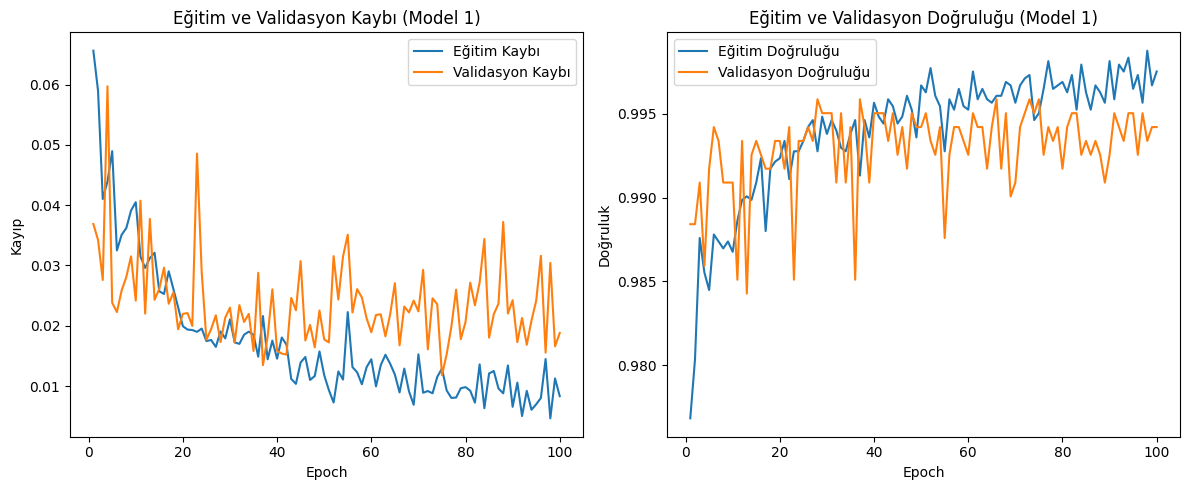

In [17]:
# Eğitim kaybı ve doğruluk eğrileri
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']

# Epoch'lar
epochs1 = range(1, len(loss1) + 1)

# Kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs1, loss1, label='Eğitim Kaybı')
plt.plot(epochs1, val_loss1, label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs1, accuracy1, label='Eğitim Doğruluğu')
plt.plot(epochs1, val_accuracy1, label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

Grafikte, eğitim ve validasyon kaybı ile doğruluk metriklerinin seyri incelenmiştir.

Sol taraftaki kayıp grafiğinde, eğitim kaybının istikrarlı bir şekilde azaldığı ve düşük seviyelerde kaldığı görülüyor. Validasyon kaybı başlangıçta dalgalı bir seyir izlese de genel olarak azalma eğiliminde. Ancak, validasyon kaybının eğitim kaybına kıyasla daha dalgalı olması, modelin validasyon setine tam uyum sağlama sürecinde zaman zaman zorluk yaşadığını gösterebilir. Bu durum, modelin veri setine bağlı olarak sınırlı bir genelleme kapasitesine sahip olabileceğine işaret edebilir. Validasyon kaybındaki dalgalanmaları azaltmak için daha düşük bir öğrenme oranı denenebilir. 

Sağ taraftaki doğruluk grafiğinde, hem eğitim hem de validasyon doğruluğu düzenli bir artış gösteriyor. Eğitim doğruluğu, validasyon doğruluğuna kıyasla daha stabil bir artış sergiliyor ve yüksek değerlere ulaşıyor (> %99.5). Validasyon doğruluğu ise biraz daha dalgalı, ancak genel eğilimi eğitim doğruluğuna paralel. Bu, modelin genelde güçlü bir performansa sahip olduğunu ve overfitting riskinin düşük olduğunu işaret ediyor.

Genel olarak, model hem eğitim hem de validasyon setlerinde yüksek doğruluk ve düşük kayıp seviyeleri ile iyi bir performans göstermektedir. Ancak validasyon kaybındaki dalgalanmalar, daha fazla veri artırma tekniklerinin uygulanması veya regularization yöntemlerinin artırılmasıyla dengelenebilir. Bu grafikler, modelin genelleme yeteneği açısından güçlü bir temel sunduğunu göstermektedir.

### ROC Eğrisi ve AUC

48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 666ms/step


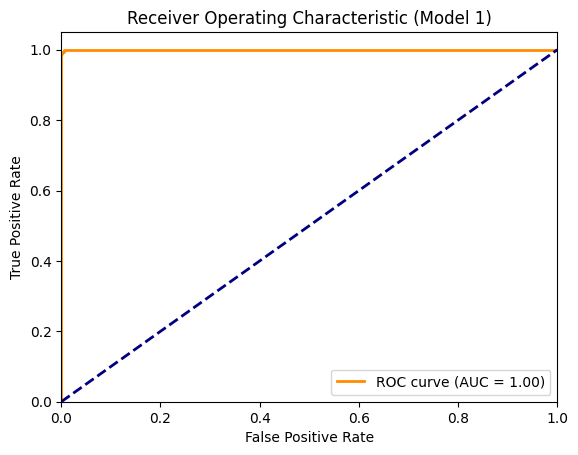

In [18]:
# Test seti tahminleri
y_pred_probs1 = model1.predict(test_generator)[:, 1]  # Pozitif sınıf için olasılıklar
y_true1 = test_generator.classes  # Gerçek etiketler

# ROC eğrisi için
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred_probs1)
roc_auc1 = auc(fpr1, tpr1)

# ROC eğrisini çizdir
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Model 1)')
plt.legend(loc='lower right')
plt.show()

Bu ROC eğrisi ve AUC (Area Under the Curve) değeri, Model 1'in sınıflandırma performansını değerlendirmek için kritik bir ölçüm sunmaktadır. Eğrideki AUC değeri tam olarak 1.00'dir, bu da modelin pozitif ve negatif sınıfları %100 doğrulukla ayırabildiğini gösterir. ROC eğrisinin grafiğin sol üst köşesine yakın ilerlemesi, modelin yanlış pozitif oranı sıfıra yakınken dahi yüksek bir gerçek pozitif oranına ulaştığını ifade eder. Bu durum, modelin pozitif sınıfları ayırt etmede son derece hassas olduğunu ve yanlış sınıflandırma oranının neredeyse sıfır olduğunu kanıtlar. Bu kadar yüksek bir performans gerçek dünyada nadiren görülse de, modelin veri seti üzerinde oldukça iyi çalıştığını göstermektedir. Ancak, bu mükemmel sonuçlar potansiyel bir overfitting durumuna işaret edebilir. Bu riskin değerlendirilmesi için modelin farklı veri setleri üzerinde veya çapraz doğrulama yöntemleriyle test edilmesi önerilir. Genel olarak, bu sonuçlar, modelin etkili bir şekilde optimize edildiğini ve veri seti üzerinde son derece başarılı bir performans gösterdiğini ortaya koymaktadır.

### Confusion Matrix 

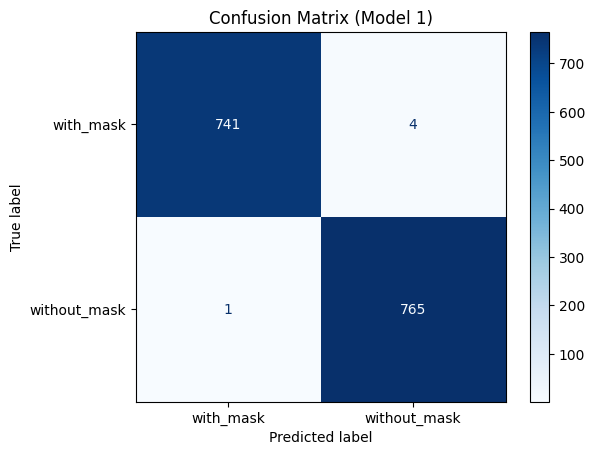

In [21]:
# Tahmin edilen sınıflar
y_pred_classes1 = (y_pred_probs1 > 0.5).astype(int)  # Olasılıkları sınıf etiketlerine çevir

# Karışıklık matrisi
cm1 = confusion_matrix(y_true1, y_pred_classes1)

# Çizdirme
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=test_generator.class_indices.keys())
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Model 1)')
plt.show()

Bu karışıklık matrisi, Model 1'in "with_mask" (maske takan) ve "without_mask" (maske takmayan) sınıflarını ayırt etme performansını detaylı bir şekilde göstermektedir. Matris incelendiğinde, modelin doğru tahminlerinin oldukça yüksek olduğu görülmektedir. Toplamda 741 örnek doğru bir şekilde "with_mask" sınıfında ve 765 örnek doğru bir şekilde "without_mask" sınıfında tahmin edilmiştir. Yanlış tahminler ise oldukça sınırlıdır; yalnızca 4 örnek yanlış bir şekilde "with_mask" olarak tahmin edilirken gerçekte "without_mask" sınıfına aittir. Ayrıca yalnızca 1 örnek "without_mask" olarak tahmin edilirken gerçekte "with_mask" sınıfına aittir. Bu sonuçlar, modelin her iki sınıfı da yüksek doğrulukla ayırt edebildiğini ve hatalarının son derece düşük olduğunu göstermektedir.

Modelin genel performansı oldukça başarılıdır ve sınıflandırma görevinde dengeli bir yaklaşım sergilemektedir. Doğru tahmin oranlarının bu kadar yüksek olması, modelin veri seti üzerindeki genelleme yeteneğinin güçlü olduğunu kanıtlamaktadır. Yanlış tahminlerin azaltılması için ek veri artırma teknikleri veya sınıflar arasındaki olası örtüşme noktalarının daha derinlemesine analizi yapılabilir. Ancak mevcut sonuçlar, modelin uygulama ortamında güvenle kullanılabileceğini ve sınıflandırma görevinde etkili bir çözüm sunduğunu göstermektedir.

### Model Metrikleri

In [22]:
# Doğruluk hesabı
accuracy1 = accuracy_score(y_true1, y_pred_classes1)
print(f"Model 1 Accuracy: {accuracy1:.2f}")

# Precision (Duyarlılık)
precision1 = precision_score(y_true1, y_pred_classes1)
print(f"Model 1 Precision (Duyarlılık): {precision1:.2f}")

# Recall (Hassasiyet / Duyarlılık)
recall1 = recall_score(y_true1, y_pred_classes1)
print(f"Model 1 Recall (Hassasiyet): {recall1:.2f}")

# Specificity (Özgüllük)
specificity1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])  # TN / (TN + FP)
print(f"Model 1 Specificity (Özgüllük): {specificity1:.2f}")

# F1-score
f1_1 = f1_score(y_true1, y_pred_classes1)
print(f"Model 1 F1-score: {f1_1:.2f}")

Model 1 Accuracy: 1.00
Model 1 Precision (Duyarlılık): 0.99
Model 1 Recall (Hassasiyet): 1.00
Model 1 Specificity (Özgüllük): 0.99
Model 1 F1-score: 1.00


Accuracy (Doğruluk), modelin tüm örneklerdeki doğru tahmin oranını ifade eder ve 1.00 değeri, modelin verisetinde neredeyse hatasız çalıştığını göstermektedir. Precision (Duyarlılık) ise modelin pozitif tahminlerinin doğruluğunu ölçer ve 0.99 değeri, modelin pozitif sınıfları genellikle doğru bir şekilde tahmin ettiğini ancak çok az bir oranda yanlış pozitif bulunduğunu göstermektedir. Recall (Hassasiyet) değeri 1.00 olduğu için modelin tüm pozitif örnekleri doğru bir şekilde tespit ettiği anlaşılmaktadır. Bu, modelin pozitif sınıf için eksiksiz bir tahmin yeteneğine sahip olduğunu gösterir.

Specificity (Özgüllük), modelin negatif sınıfları doğru tahmin etme oranını ifade eder ve 0.99 değeri ile negatif sınıfta da yüksek bir doğruluk sağlandığını ortaya koymaktadır. Son olarak, F1-score değerinin 1.00 olması, modelin Precision ve Recall arasında mükemmel bir denge kurduğunu ve genel olarak üstün bir performans sergilediğini göstermektedir.

Bu metrikler, modelin her iki sınıfta da dengeli ve güvenilir bir şekilde çalıştığını kanıtlamaktadır. Model, hem pozitif hem de negatif sınıflarda yüksek doğrulukla çalışırken hata oranını neredeyse sıfıra indirmiştir. Uygulama açısından, bu sonuçlar modelin gerçek dünya verileriyle başarılı bir şekilde çalışabileceğini ve sınıflandırma görevinde güvenilir bir çözüm sunduğunu göstermektedir. Ancak farklı veri setlerinde benzer sonuçlar elde edilip edilmediğini test etmek, genelleme yeteneğini daha iyi değerlendirmek için faydalı olabilir.

### Model 2 with Data Augmentation

In [28]:
# Eğitim verisi için veri artırma (data augmentation)
train_datagen2 = ImageDataGenerator(
    rescale=1.0/255,  # Normalizasyon
    rotation_range=10,  # Resim döndürme
    width_shift_range=0.1,  # Yatay kaydırma
    height_shift_range=0.1,  # Dikey kaydırma
    shear_range=0.1,  # Kesme (shear) işlemi
    zoom_range=0.1,  # Yakınlaştırma
    horizontal_flip=True,  # Yatay çevirme
    fill_mode='nearest',  # Boş alanları doldurma yöntemi
    validation_split=0.2  # Eğitim ve validasyon için %80 - %20 ayırma
)

# Validasyon ve test için veri artırma olmadan normalizasyon
val_test_datagen2 = ImageDataGenerator(
    rescale=1.0/255  # Sadece normalizasyon
)

# Resim boyutu ve batch size
img_size = (224, 224)  # Resim boyutları
batch_size = 32  # Batch boyutu

# Eğitim verisi (%64, çünkü eğitim+validasyon %80, bunun %80'i eğitim)
train_generator2 = train_datagen2.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,  # Resimleri yeniden boyutlandır
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='training'  # Eğitim seti
)

# Validasyon verisi (%16, çünkü eğitim+validasyon %80, bunun %20'si validasyon)
val_generator2 = train_datagen2.flow_from_directory(
    directory='working/train_val',  # Eğitim+validasyon verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    subset='validation'  # Validasyon seti
)

# Test verisi (%20 bağımsız veri)
test_generator2 = val_test_datagen2.flow_from_directory(
    directory='working/test',  # Test verisi
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # İkili sınıflandırma
    shuffle=False  # Test verisini karıştırma
)

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [29]:
# Modelin tanımlanması
model2 = Model(inputs=base_model.input, outputs=predictions)

# Adam optimizer'ı 0.0005 öğrenme oranı ile oluşturma
adam_optimizer = Adam(learning_rate=0.0005)

# Modelin derlenmesi
model2.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model2.summary()

# En iyi ağırlıkları kaydetmek için ModelCheckpoint
checkpoint2 = ModelCheckpoint(
    filepath='working/weights/model2.keras',  # Ağırlıkların kaydedileceği dosya adı
    monitor='val_loss',  # Validasyon kaybını izler
    save_best_only=True,  # En iyi model kaydedilir
    mode='min',  # En düşük val_loss'u hedefler
    verbose=1
)

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

# Modelin eğitilmesi
history2 = model2.fit(
    train_generator2,
    validation_data=val_generator2,  # Validation seti doğrulama olarak kullanılır
    epochs=100,
    callbacks=[checkpoint2, early_stopping,reduce_lr]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9941 - loss: 0.0204
Epoch 1: val_loss improved from inf to 0.02659, saving model to working/weights/model2.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 135s 865ms/step - accuracy: 0.9941 - loss: 0.0204 - val_accuracy: 0.9934 - val_loss: 0.0266 - learning_rate: 5.0000e-04
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9931 - loss: 0.0190
Epoch 2: val_loss did not improve from 0.02659
152/152 ━━━━━━━━━━━━━━━━━━━━ 130s 851ms/step - accuracy: 0.9931 - loss: 0.0190 - val_accuracy: 0.9917 - val_loss: 0.0305 - learning_rate: 5.0000e-04
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9942 - loss: 0.0185
Epoch 3: val_loss did not improve from 0.02659
152/152 ━━━━━━━━━━━━━━━━━━━━ 129s 843ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9950 - val_loss: 0.0271 - learning_rate: 5.0000e-04
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9949 - loss: 0.0145
Epoch 4: v

Bu model, önceden tanımlanmış DenseNet121 tabanlı bir mimarinin üzerine inşa edilmiş olup, optimize edilmiş parametrelerle yeniden derlenmiştir. Model 2, Model 1'e kıyasla bazı farklılıklar içerir. Öncelikle, bu modelde kullanılan Adam optimizer'ın öğrenme oranı 0.001 yerine 0.0005 olarak ayarlanmıştır. Daha düşük bir öğrenme oranı, ağırlık güncellemelerinin daha küçük adımlarla yapılmasını sağlayarak modelin daha hassas bir şekilde öğrenmesine olanak tanır ve eğitim sırasında daha stabil bir performans sergilemesini sağlar. Bu, özellikle validasyon kaybındaki dalgalanmaları azaltmak ve modelin genelleme yeteneğini artırmak için önemlidir.

Modelin eğitim sürecinde, EarlyStopping mekanizması kullanılmıştır. Bu, modelin performansında bir iyileşme olmadığında eğitimi erken durdurmayı sağlar ve overfitting riskini azaltır. EarlyStopping parametresi olarak patience=25 seçilmiştir, bu da modelin belirli bir süre boyunca iyileşme göstermemesi durumunda eğitimi durduracağını ifade eder. Ayrıca, ReduceLROnPlateau mekanizması, validasyon kaybında iyileşme gözlenmediğinde öğrenme oranını 10 kat azaltarak daha uzun süreli öğrenmeyi teşvik etmektedir. Bu özellik, modelin lokal minimumlardan kaçmasına ve daha iyi bir global minimuma ulaşmasına yardımcı olabilir.

Model 2'de, eğitim ve validasyon verileri için kullanılan train_generator2 ve val_generator2 içerisinde, veri artırma (data augmentation) işlemi daha geniş bir şekilde uygulanmıştır. Veri artırma sayesinde, eğitim setinin çeşitliliği artırılarak modelin genelleme yeteneği güçlendirilmiştir. Bunun yanı sıra, validasyon ve test verileri için yalnızca normalizasyon uygulanmış, veri artırma işlemi dışarıda bırakılmıştır. Bu, validasyon setinin eğitim süreci boyunca modelin performansını gerçekçi bir şekilde yansıtmasını sağlamaktadır.

Model 2'nin eğitim sürecinde, en iyi model ağırlıklarının kaydedilmesi için bir ModelCheckpoint mekanizması tanımlanmıştır. Bu, validasyon kaybı (val_loss) en düşük seviyeye ulaştığında modelin ağırlıklarını kaydederek performansı optimize etmeyi hedefler. Model 1 ile kıyaslandığında, Model 2'nin daha hassas bir şekilde optimize edildiği ve eğitim sırasında daha fazla düzenleyici mekanizmanın (ör. EarlyStopping ve ReduceLROnPlateau) devreye alındığı görülmektedir.

Sonuç olarak, Model 2'nin yapılandırması, Model 1'e kıyasla daha düşük bir öğrenme oranı, veri artırma tekniklerinin etkili kullanımı ve düzenleme mekanizmaları ile eğitimin daha stabil ve genelleme kapasitesinin daha güçlü olmasını hedeflemektedir. Bu farklılıklar, Model 2'nin özellikle overfitting'e karşı daha dayanıklı ve daha geniş veri setleri üzerinde uygulanabilir olmasını sağlamaktadır. Eğitim sonuçları bu değişikliklerin etkisini değerlendirmek için kilit bir role sahip olacaktır.

In [30]:
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,145,928 (31.07 MB)

 Trainable params: 369,474 (1.41 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 738,950 (2.82 MB)

In [31]:
# Kaydedilen ağırlıkları yükle
model2.load_weights('working/weights/model2.keras')

# Test setinde modeli değerlendir
test_loss2, test_accuracy2 = model2.evaluate(test_generator2)
print(f"Model 1 Test Loss: {test_loss2}")
print(f"Model 1 Test Accuracy: {test_accuracy2}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 648ms/step - accuracy: 0.9960 - loss: 0.0090
Model 1 Test Loss: 0.011577712371945381
Model 1 Test Accuracy: 0.9960291385650635


Modelin eğitimi sırasında elde edilen sonuçlar oldukça başarılıdır. Modelin toplam parametre sayısı 8,145,928 iken, bunun 369,474'ü eğitilebilir durumdadır. Adam optimizer ile 0.0005 öğrenme oranı kullanılarak model derlenmiş ve "sparse_categorical_crossentropy" kayıp fonksiyonu seçilmiştir. ModelCheckpoint, EarlyStopping ve ReduceLROnPlateau gibi callback'ler, modelin performansını optimize etmek için etkili bir şekilde kullanılmıştır. Eğitim sonuçlarına göre, model 100 epoch boyunca eğitilirken erken durdurma mekanizması devreye girmiştir. En iyi doğrulama kaybı 0.01583 seviyesinde gözlenmiş ve modelin doğrulama doğruluğu %99.42’ye ulaşmıştır. Sonuç olarak, hem düşük kayıp hem de yüksek doğruluk oranları, modelin sınıflandırma görevinde oldukça güçlü bir performans sergilediğini göstermektedir.

### Eğitim ve Validasyon Kaybı ile Doğruluğu

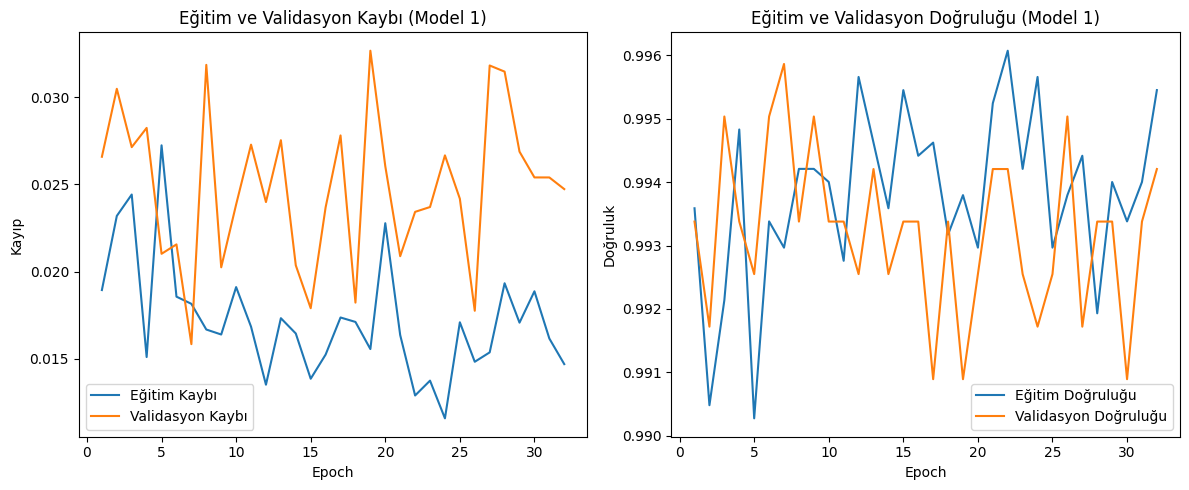

In [32]:
# Eğitim kaybı ve doğruluk eğrileri
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

# Epoch'lar
epochs2 = range(1, len(loss2) + 1)

# Kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs2, loss2, label='Eğitim Kaybı')
plt.plot(epochs2, val_loss2, label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs2, accuracy2, label='Eğitim Doğruluğu')
plt.plot(epochs2, val_accuracy2, label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu (Model 1)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

Grafikte eğitim ve validasyon kaybı ile doğruluğu zamanla izlenmiştir. Soldaki grafik, modelin eğitim ve validasyon kaybını göstermektedir. Eğitim kaybının azaldığı ve düşük seviyelerde sabitlendiği görülmektedir, bu da modelin iyi bir şekilde öğrenim sağladığını gösterir. Ancak, validasyon kaybındaki dalgalanmalar, modelin doğrulama verisine tam olarak genel bir uyum sağlayamadığını veya bazı epoch'larda overfitting riskinin bulunduğunu işaret edebilir.

Sağdaki grafik ise eğitim ve validasyon doğruluklarını karşılaştırmaktadır. Eğitim doğruluğunun yüksek seviyelerde olduğu ve validasyon doğruluğunun genelde paralel bir seyir izlediği görülmektedir. Yine de, validasyon doğruluğunda bazı dalgalanmalar mevcuttur; bu durum, modelin validasyon verisine tam uyum sağlayabilmesi için daha fazla ince ayar gerektiğini gösterebilir.

Genel olarak, modelin eğitim performansı güçlüdür, ancak validasyon setinde daha tutarlı bir sonuç elde etmek için hiperparametre ayarları veya veri çeşitliliği üzerinde çalışılabilir. Özellikle, erken durdurma ve öğrenme oranı azaltma gibi callback'lerin modelin aşırı öğrenimini önlemede etkili olduğu anlaşılmaktadır.

### ROC Eğrisi ve AUC

48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 662ms/step


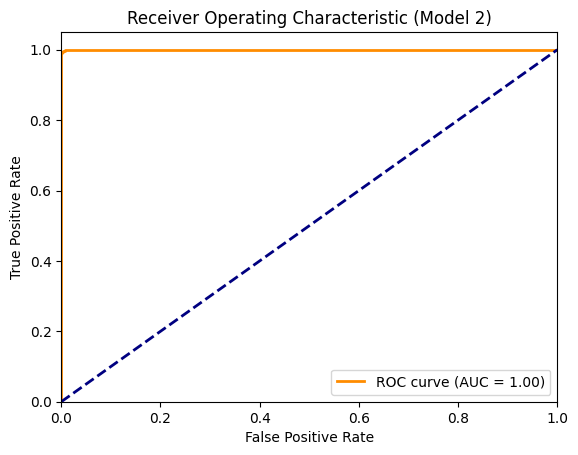

In [33]:
# Test seti tahminleri
y_pred_probs2 = model2.predict(test_generator2)[:, 1]  # Pozitif sınıf için olasılıklar
y_true2 = test_generator2.classes  # Gerçek etiketler

# ROC eğrisi için
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred_probs2)
roc_auc2 = auc(fpr2, tpr2)

# ROC eğrisini çizdir
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Model 2)')
plt.legend(loc='lower right')
plt.show()

Grafikte, Model 2'nin ROC (Receiver Operating Characteristic) eğrisi gösterilmektedir. ROC eğrisi, modelin sınıflandırma performansını ölçmek için kullanılan önemli bir metriği ifade eder. Grafik üzerinde turuncu çizgi, modelin gerçek pozitif oranını (True Positive Rate) yanlış pozitif oranına (False Positive Rate) göre nasıl değiştirdiğini gösterirken, mavi kesikli çizgi rastgele bir sınıflandırıcının performansını temsil eder.

Bu grafikte AUC (Area Under Curve) değeri 1.00 olarak hesaplanmıştır, bu da modelin mükemmel bir sınıflandırma performansına sahip olduğunu gösterir. Model, sınıflandırma görevinde yanlış pozitif oranı düşükken dahi yüksek bir doğru pozitif oranını sürdürebilmektedir. Bu sonuç, modelin hem pozitif hem de negatif sınıfları başarılı bir şekilde ayırt ettiğini ve neredeyse hiç hata yapmadığını göstermektedir.

### Confusion Matrix

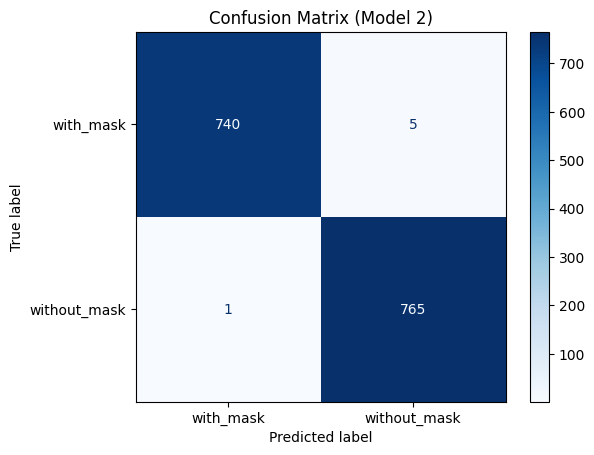

In [34]:
# Tahmin edilen sınıflar
y_pred_classes2 = (y_pred_probs2 > 0.5).astype(int)  # Olasılıkları sınıf etiketlerine çevir

# Karışıklık matrisi
cm2 = confusion_matrix(y_true2, y_pred_classes2)

# Çizdirme
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=test_generator2.class_indices.keys())
disp1.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Model 2)')
plt.show()

Karışıklık matrisi, Model 2'nin sınıflandırma performansını detaylı bir şekilde ortaya koymaktadır. İki sınıf olan "with_mask" ve "without_mask" için modelin yaptığı doğru ve yanlış tahminler bu matris üzerinde gösterilmiştir.

Model, "with_mask" sınıfındaki örneklerden 740 tanesini doğru bir şekilde sınıflandırırken yalnızca 5 örneği yanlış bir şekilde "without_mask" olarak tahmin etmiştir. "Without_mask" sınıfında ise 765 doğru sınıflandırma yapılmış ve sadece 1 yanlış tahmin gerçekleştirilmiştir.

Bu sonuçlar, modelin çok yüksek bir doğruluk oranına sahip olduğunu göstermektedir. Yanlış tahminler oldukça azdır ve bu, modelin hem "with_mask" hem de "without_mask" sınıflarını ayırt etmede oldukça başarılı olduğunu ifade eder. Bununla birlikte, böylesine düşük hata oranları veri setinin dengesini ve modelin genelleme yeteneğini gözden geçirmeyi gerektirebilir, çünkü bu performans overfitting riskine işaret edebilir. Daha çeşitli ve zorlu bir test veri setiyle modelin performansı yeniden değerlendirilmelidir.

### Model Metrikleri

In [36]:
# Doğruluk hesabı
accuracy2 = accuracy_score(y_true2, y_pred_classes2)
print(f"Model 2 Accuracy: {accuracy2:.2f}")

# Precision (Duyarlılık)
precision2 = precision_score(y_true2, y_pred_classes2)
print(f"Model 2 Precision (Duyarlılık): {precision2:.2f}")

# Recall (Hassasiyet / Duyarlılık)
recall2 = recall_score(y_true2, y_pred_classes2)
print(f"Model 2 Recall (Hassasiyet): {recall2:.2f}")

# Specificity (Özgüllük)
specificity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])  # TN / (TN + FP)
print(f"Model 2 Specificity (Özgüllük): {specificity2:.2f}")

# F1-score
f1_2 = f1_score(y_true2, y_pred_classes2)
print(f"Model 2 F1-score: {f1_2:.2f}")

Model 2 Accuracy: 1.00
Model 2 Precision (Duyarlılık): 0.99
Model 2 Recall (Hassasiyet): 1.00
Model 2 Specificity (Özgüllük): 0.99
Model 2 F1-score: 1.00


 Model 2'nin genel performansı mükemmel düzeydedir. Precision ve specificity gibi metriklerde ufak bir düşüş gözlemlense de bu farklar, modelin genelleme yeteneğini etkilemeyecek kadar küçüktür. Bu sonuçlar, Model 2'nin hem pozitif hem de negatif sınıfları dengeli bir şekilde ayırt edebildiğini ve çok az hata yaptığını göstermektedir.

### Değerlendirme

Model 1 ve Model 2 metrikleri karşılaştırıldığında, her iki modelin de aynı accuracy (1.00), recall (1.00), specificity (0.99) ve F1-score (1.00) değerlerine sahip olduğu görülmektedir. Bu, her iki modelin de genel olarak oldukça yüksek performans sergilediğini ve sınıflandırma görevinde başarılı olduğunu göstermektedir.

Ancak, Model 1 ve Model 2 arasındaki küçük farklar daha çok karışıklık matrislerinden ve tahmin detaylarından kaynaklanmaktadır. Örneğin, "with_mask" sınıfında Model 1 bir tahmin daha doğru yapmıştır (741 doğru, 4 yanlış), bu da precision (duyarlılık) değerinde küçük bir fark yaratabilir. Bunun dışında, diğer metriklerdeki eşitlik, her iki modelin performanslarının birbirine çok yakın olduğunu doğrular.

Bu sonuçlara dayanarak, Model 1, "with_mask" sınıfı için hafif bir avantaj gösterirken, Model 2 genel olarak benzer bir başarı sunmaktadır. Performansın neredeyse aynı olması, her iki modelin de kullanılabilir olduğunu, ancak küçük detayların seçim sürecinde rol oynayabileceğini göstermektedir. İhtiyaca göre daha az hata yapan model tercih edilebilir.

Model 1 ve Model 2'nin eğitim ve validasyon kaybı ile doğruluk grafikleri karşılaştırıldığında, aralarında dikkat çeken bazı farklılıklar gözlemlenebilir.

##### Kaybın Seyri
Model 1'de eğitim kaybı, istikrarlı bir şekilde azalmış ve düşük seviyelerde sabitlenmiştir. Validasyon kaybı ise daha dalgalı bir seyir izlemekle birlikte genelde azalma eğilimindedir. Model 2'de ise eğitim ve validasyon kayıpları daha hızlı bir şekilde azalırken validasyon kaybında Model 1’e kıyasla daha az dalgalanma görülmüştü. Bu durum, Model 2’nin validasyon setine uyum sağlama kapasitesinin daha iyi olduğunu gösterebilir.

##### Doğruluğun Seyri
Model 1'de eğitim doğruluğu istikrarlı bir artış göstermiş, validasyon doğruluğu ise daha dalgalı bir şekilde yükselmiştir. Bunun aksine, Model 2’de hem eğitim hem de validasyon doğruluğu daha az dalgalı bir seyir izlemiş ve Model 1’den daha hızlı şekilde yüksek değerlere ulaşmıştır. Bu, Model 2’nin genelleme yeteneğinin biraz daha güçlü olduğunu gösterebilir.

##### Farklılıkların Yorumu
Model 1, validasyon seti üzerindeki dalgalanmalar nedeniyle biraz daha hassas bir ayar gerektirebilir. Ancak genel olarak başarılı bir öğrenme süreci sergilemiştir.
Model 2, daha az dalgalanma ve hızlı öğrenme kapasitesiyle daha dengeli bir performans sergilemiştir. Bu durum, Model 2’nin hiperparametre ayarlarının daha optimal olduğunu veya validasyon setine daha iyi genelleme yapabildiğini işaret eder.
Sonuç olarak, Model 2'nin daha az dalgalanması ve hızlı öğrenimi, performans açısından avantaj sağlamaktadır. Ancak Model 1 de yüksek doğruluk değerleri ve düşük kayıplarıyla hala güçlü bir alternatif olmaya devam etmektedir. Her iki modelin, veri setine ve proje gereksinimlerine göre tercih edilebileceği söylenebilir.